In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import datetime
import copy
import time
import wandb
import pickle as pkl

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.fit import plot_histogram, plot_all_histograms, plot_mean_variance, plot_scatter, plot_kl_divergence, plot_heatmap_distribution_sigmas, plot_all_params, plot_all_losses, plot_all_buckets
import yaml

In [10]:
predictions_dict = {}

In [11]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

In [12]:
config_filenames = ['uncer.yaml','default.yaml']
model_names = ['MCMC','BO']

In [13]:
configs = [read_config(cnf) for cnf in config_filenames]

In [14]:
dates = []
for i in range(1):
    dateT = datetime.datetime.now() - datetime.timedelta(days = 20) -datetime.timedelta(days = 30*i)
    dates.append(dateT)
dates

[datetime.datetime(2020, 10, 23, 5, 40, 55, 779907)]

In [ ]:
num_rep_trials = 5
for tag, end_date in enumerate(dates):
    predictions_dict[tag] = {}
    for j, config in enumerate(configs):
        predictions_dict[tag][model_names[j]] = {}
        config_params = copy.deepcopy(config['fitting'])
        config_params['split']['end_date'] = end_date.date()
        for k in range(num_rep_trials):
            predictions_dict[tag][model_names[j]][f'm{k}'] = single_fitting_cycle(**config_params)

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 17/10000 [00:00<01:01, 163.19it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 169                 | 170                 | 171                 | 172                 | 173                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-12 00:00:00 | 2020-10-13 00:00:00 | 2020-10-14 00:00:00 | 2020-10-15 00:00:00 | 2020-10-16 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 230939.29           | 232863.71           | 234602.0            | 236721.0            | 238544.0   

  0%|          | 16/10000 [00:00<01:03, 157.06it/s]

The acceptance ratio is -------->  0.0001
The explored steps are -------->  0
The optimized steps are -------->  1


  0%|          | 16/10000 [00:00<01:05, 151.91it/s]

The acceptance ratio is -------->  0.0001
The explored steps are -------->  0
The optimized steps are -------->  1


  0%|          | 15/10000 [00:00<01:07, 147.98it/s]

The acceptance ratio is -------->  0.0001
The explored steps are -------->  0
The optimized steps are -------->  1


  0%|          | 0/1500 [00:00<?, ?it/s]

The acceptance ratio is -------->  0.0001
The explored steps are -------->  0
The optimized steps are -------->  1
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 168.92358152572712,
    'I_hosp_ratio': 103.58073881518182,
    'P_fatal': 221.21422323930756,
    'T_inc': 74.15950932574752,
    'T_inf': 103.94621870939692,
    'T_recov': 878.6469720106074,
    'T_recov_fatal': 55.50934098641136,
    'lockdown_R0': 123.66543323809293,
    'sigma': 744.4977866694817}


  1%|          | 11/1500 [00:00<00:14, 104.28it/s]

2.8943199591094206


100%|██████████| 1500/1500 [00:15<00:00, 98.48it/s]


2.8943199591094206
best parameters
 OrderedDict([('lockdown_R0', 0.7060623425369683), ('T_inc', 4.15493028259791), ('T_inf', 3.837814537171083), ('T_recov', 34.01713322486832), ('T_recov_fatal', 21.862465491137463), ('P_fatal', 0.01812796215987895), ('E_hosp_ratio', 0.7400581343648156), ('I_hosp_ratio', 0.08342514872643768), ('sigma', 2.6680032806840295)])


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 17/10000 [00:00<00:58, 169.24it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 169                 | 170                 | 171                 | 172                 | 173                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-12 00:00:00 | 2020-10-13 00:00:00 | 2020-10-14 00:00:00 | 2020-10-15 00:00:00 | 2020-10-16 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 230939.29           | 232863.71           | 234602.0            | 236721.0            | 238544.0   

 45%|████▌     | 4522/10000 [00:33<00:32, 166.41it/s]

In [9]:
with open('../../misc/predictions/predictions_dict_oct.pickle', 'wb') as handle:
    pkl.dump(predictions_dict, handle)

In [10]:
with open('../../misc/predictions/predictions_dict_oct.pickle', 'rb') as handle:
    predictions_dict = pkl.load(handle)

In [11]:
trials = ['m0', 'm1', 'm2', 'm3', 'm4']

In [12]:
loss_type = ['train','val']
compartments = ['total', 'recovered', 'deceased']

In [13]:
import pandas as pd

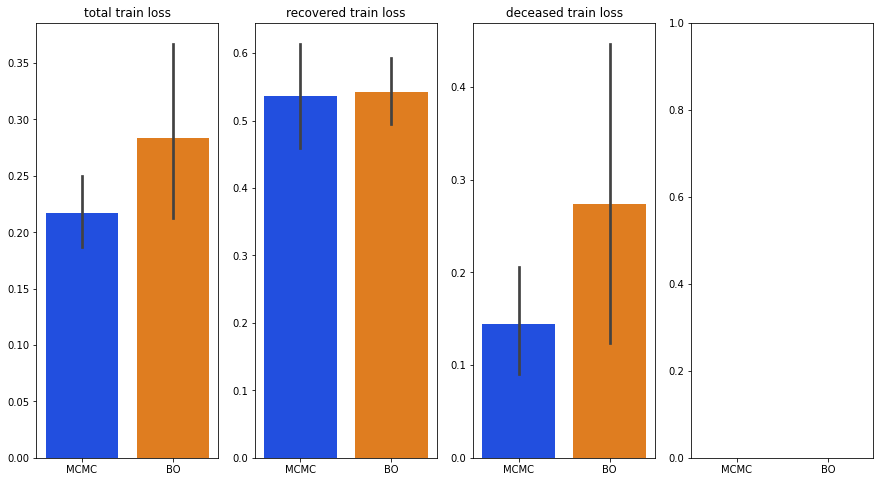

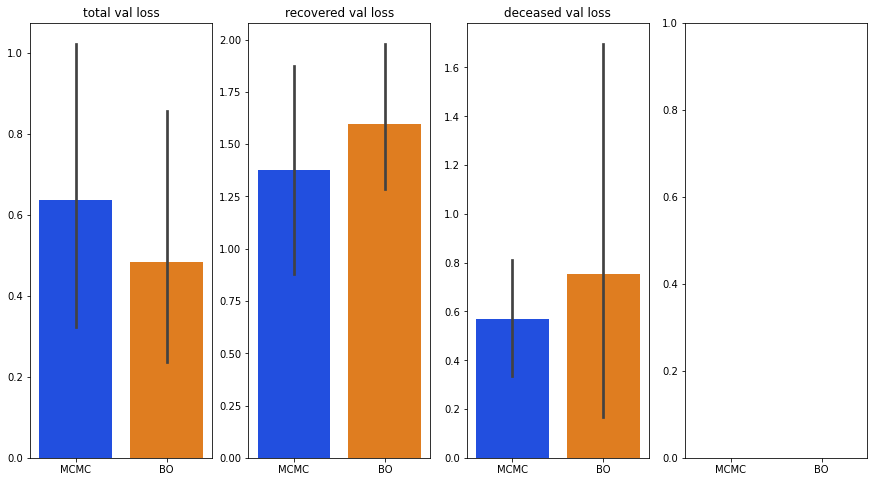

In [14]:
for l in loss_type:
    fig, AX = plt.subplots(nrows=1, ncols=4, sharex=True,figsize=(15, 8))
    for i,c in enumerate(compartments):
        MC_loss =[ predictions_dict[0]['MCMC'][i]['df_loss'][l][c] for i in trials]
        BO_loss =[ predictions_dict[0]['BO'][i]['df_loss'][l][c] for i in trials]
        data = {"MCMC":MC_loss,"BO":BO_loss}
        df = pd.DataFrame(data,columns = ["MCMC","BO"])
        sns.barplot(data =df ,ax = AX[i],palette = 'bright')
        AX[i].title.set_text(c+" "+l +" loss")

In [15]:
model_params = {
        'MCMC': [ 'lockdown_R0', 'T_inc', 'T_inf', 'T_inf', 'T_recov', 'T_recov_fatal', 'P_fatal', 'E_hosp_ratio', 'I_hosp_ratio','sigma'],
        'BO': [ 'lockdown_R0', 'T_inc', 'T_inf', 'T_inf', 'T_recov', 'T_recov_fatal', 'P_fatal', 'E_hosp_ratio', 'I_hosp_ratio','sigma'],
}

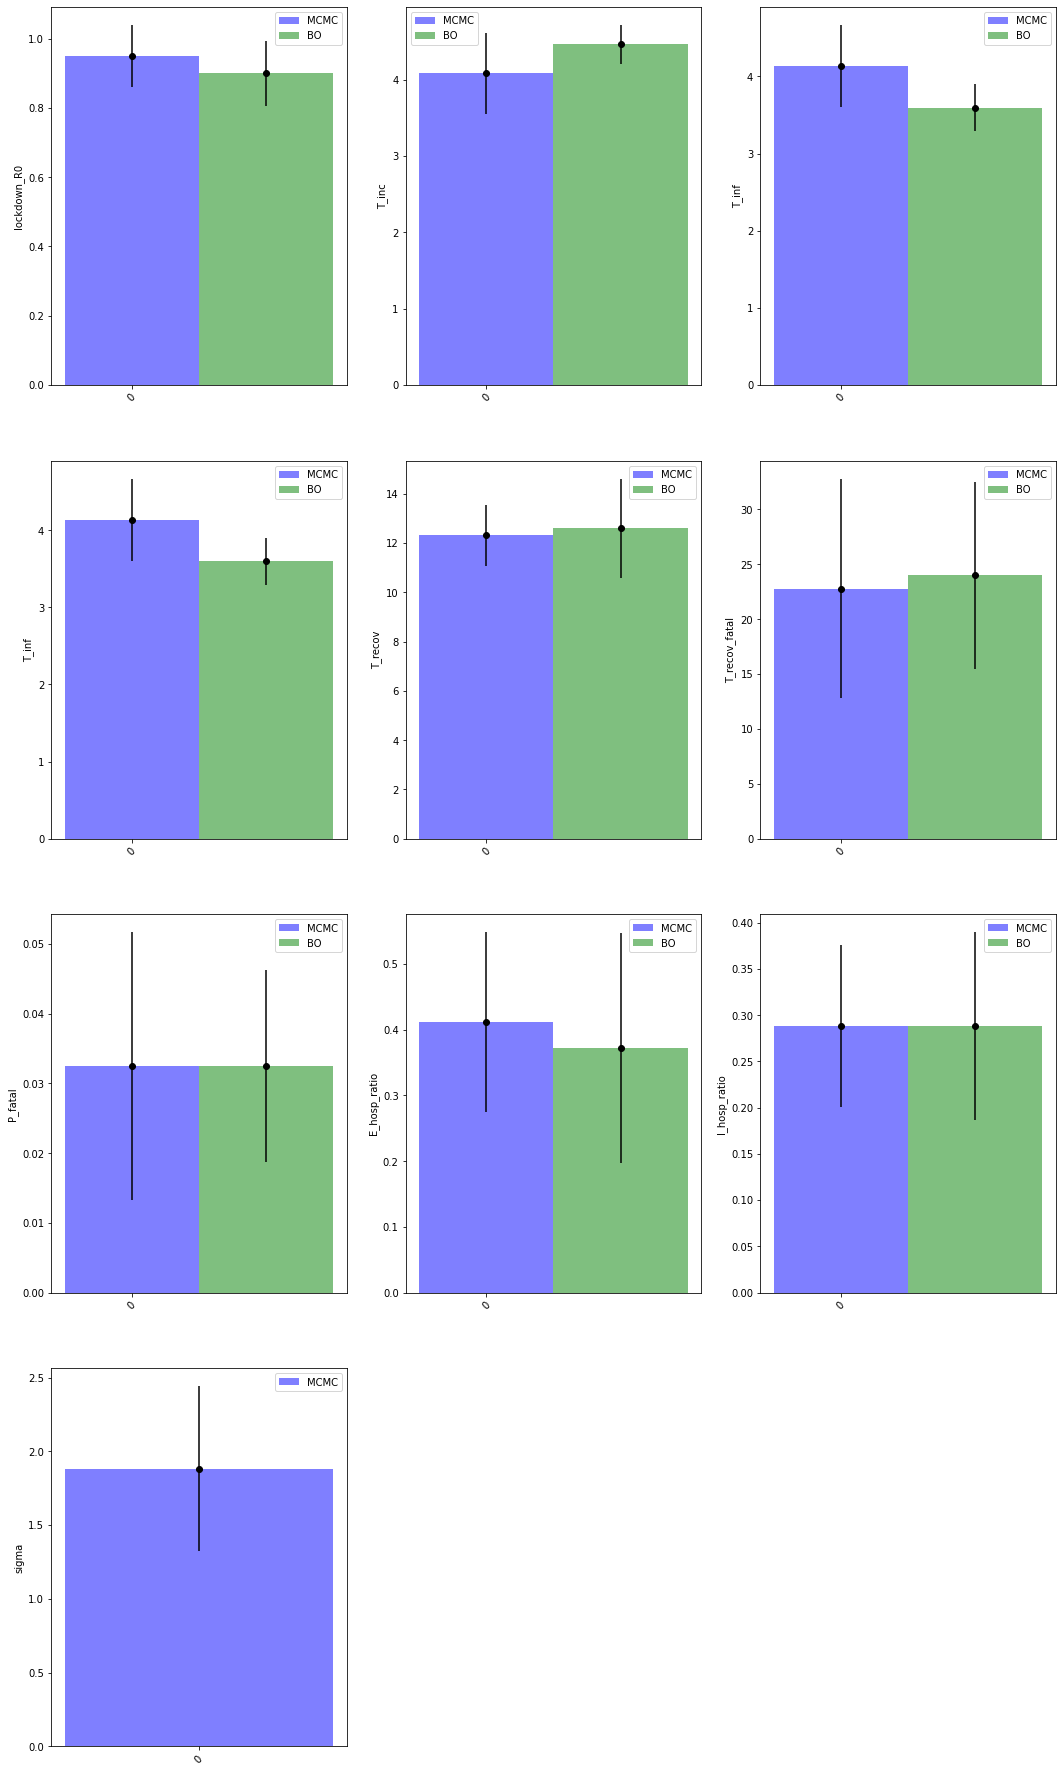

In [16]:
plot_all_params(predictions_dict, model_params, method='ensemble_combined')

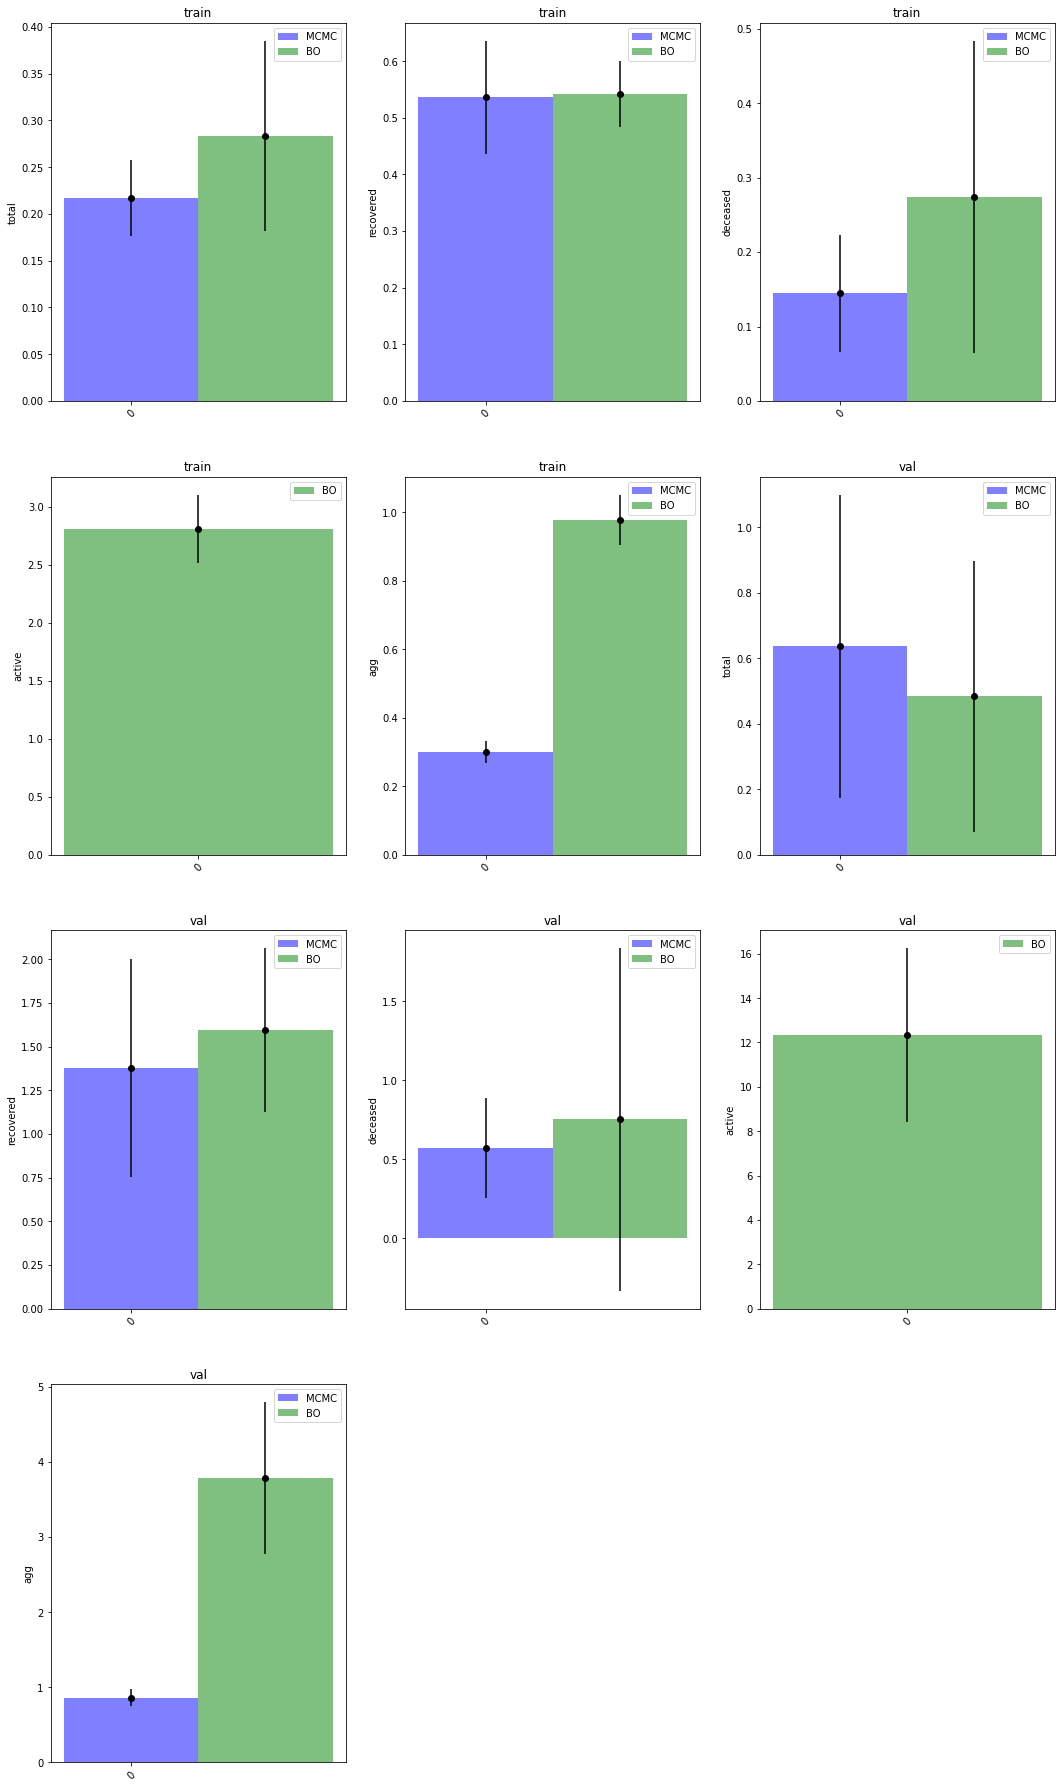

In [17]:
which_compartments = {model_names[i]: config['fitting']['loss']['loss_compartments'] for i, config in enumerate(configs)}
plot_all_losses(predictions_dict, which_losses=['train', 'val'], which_compartments=which_compartments)

In [18]:
from main.seir.forecast import _get_top_k_trials as topk

In [19]:
params,losses = topk(predictions_dict[tag][model_names[j]][f'm{k}'])

In [20]:
loss = {}
for tag in range (1):
    for j,mn in enumerate(model_names) :
        a = []
        for t in trials:
            _,l = topk(predictions_dict[tag][model_names[j]][t])
            a.append(l)
        loss[mn] = copy.copy(a)

In [23]:
(loss['MCMC'])

[array([0.22742647, 0.28478099, 0.28478099, 0.28706806, 0.28765298,
        0.29119438, 0.29267661, 0.29267661, 0.29833495, 0.30186006]),
 array([0.21831938, 0.26062787, 0.26722633, 0.26722633, 0.26722633,
        0.27294152, 0.27978364, 0.27978364, 0.28934526, 0.29964506]),
 array([0.18779477, 0.28884965, 0.29371336, 0.29371336, 0.30136067,
        0.30136067, 0.30646105, 0.30832842, 0.31045556, 0.31592374]),
 array([0.21445224, 0.23222821, 0.2359513 , 0.25933229, 0.25933229,
        0.27397184, 0.27751942, 0.28776894, 0.28776894, 0.29473354]),
 array([0.19445462, 0.19445462, 0.22708534, 0.22708534, 0.25889059,
        0.26011889, 0.26909881, 0.26909881, 0.27973268, 0.30000964])]

In [22]:
len(loss)

2